# Robustness to Outliers

Only one method, `robustdiff`, is designed intentionally to handle outliers. Here we plot its performance on simulations versus its closest cousin, `rtsdiff`. Both assume the same model and solve the Maximum A Priori (MAP) estimation problem (see Taxonomy paper), but whereas Rauch-Tung-Striebel optimizes an $\ell_2$ norm objective, the robust variant optimizes an $\ell_1$ norm or Huber loss objective. This relies on a convex solver and takes significantly longer to run but is indespensable, as shown by the outliers performance experiment in notebook 4 and examples here.

In [1]:
import numpy as np
from time import time

from pynumdiff.optimize import optimize
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous, pi_cruise_control, lorenz_x
from pynumdiff.kalman_smooth import robustdiff, rtsdiff
from pynumdiff.utils import evaluate

In [ ]:
# Collected from a previous run
cache = {(rtsdiff, pi_cruise_control): {'log_qr_ratio': 3.268359375, 'order': 1, 'forwardbackward': False},
 		(robustdiff, pi_cruise_control): {'log_q': 8.765380859375007, 'log_r': -1.081103515625, 'proc_huberM': 1.79306640625, 'meas_huberM': 1.7095703125, 'order': 3},
 		(rtsdiff, sine): {'log_qr_ratio': 7.96875, 'order': 3, 'forwardbackward': True},
 		(robustdiff, sine): {'log_q': 9.038330078125, 'log_r': 8.544262695312497, 'proc_huberM': 5.838171386718749, 'meas_huberM': 0, 'order': 2},
 		(rtsdiff, triangle): {'log_qr_ratio': 8.265625, 'order': 3, 'forwardbackward': False},
 		(robustdiff, triangle): {'log_q': 13.289532470703126, 'log_r': 10.865319824218751, 'proc_huberM': 0, 'meas_huberM': 0, 'order': 1},
 		(rtsdiff, pop_dyn): {'log_qr_ratio': 2.642578125, 'order': 3, 'forwardbackward': False},
 		(robustdiff, pop_dyn): {'log_q': 3.8404296875, 'log_r': -1.1827636718749992, 'proc_huberM': 0, 'meas_huberM': 1.36796875, 'order': 2},
 		(rtsdiff, linear_autonomous): {'log_qr_ratio': 5.3125, 'order': 2, 'forwardbackward': True},
 		(robustdiff, linear_autonomous): {'log_q': 9.349365234375, 'log_r': -1.0808227539062494, 'proc_huberM': 0, 'meas_huberM': 1.8978271484374982, 'order': 3},
 		(rtsdiff, lorenz_x): {'log_qr_ratio': 6.3984375, 'order': 2, 'forwardbackward': True},
 		(robustdiff, lorenz_x): {'log_q': 6.42748413085938, 'log_r': -1.4332870483398463, 'proc_huberM': 0, 'meas_huberM': 1.5599792480468828, 'order': 2}}

Loop particular simulation examples, plotting comparative results against the data series. 

Optimal parameters for rtsdiff on pi_cruise_control: {'log_qr_ratio': np.float64(3.268359375), 'order': 1, 'forwardbackward': False}, found in 31.79 seconds
Optimal parameters for robustdiff on pi_cruise_control: {'log_q': np.float64(8.765380859375007), 'log_r': np.float64(-1.0811035156249993), 'proc_huberM': np.float64(1.7930664062500008), 'meas_huberM': np.float64(1.7095703124999986), 'order': 3}, found in 572.50 seconds
Optimal parameters for rtsdiff on sine: {'log_qr_ratio': np.float64(7.96875), 'order': 3, 'forwardbackward': True}, found in 28.90 seconds
Optimal parameters for robustdiff on sine: {'log_q': np.float64(9.038330078125), 'log_r': np.float64(8.544262695312497), 'proc_huberM': np.float64(5.838171386718749), 'meas_huberM': np.float64(0.0002730255126953125), 'order': 2}, found in 662.86 seconds
Optimal parameters for rtsdiff on triangle: {'log_qr_ratio': np.float64(8.265625), 'order': 3, 'forwardbackward': False}, found in 31.31 seconds
Optimal parameters for robustdiff o

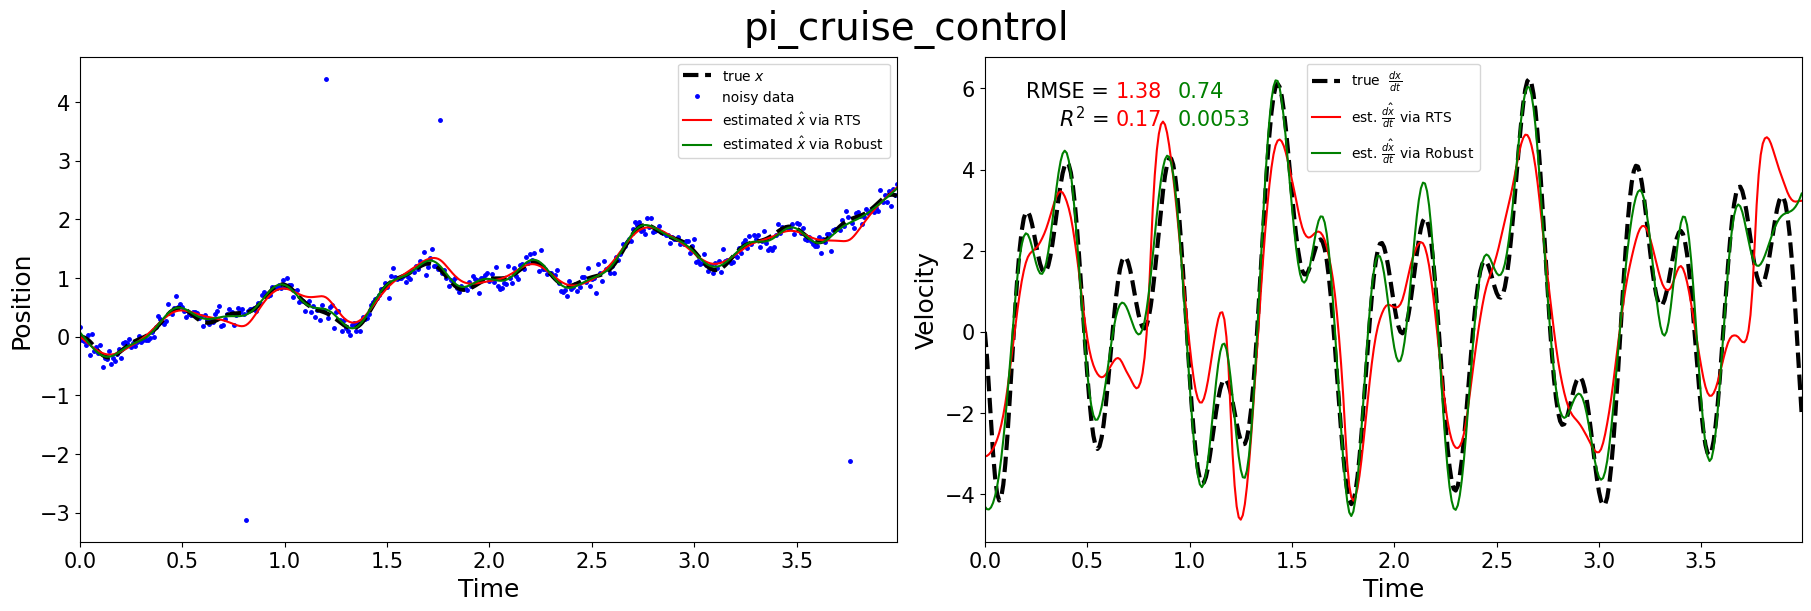

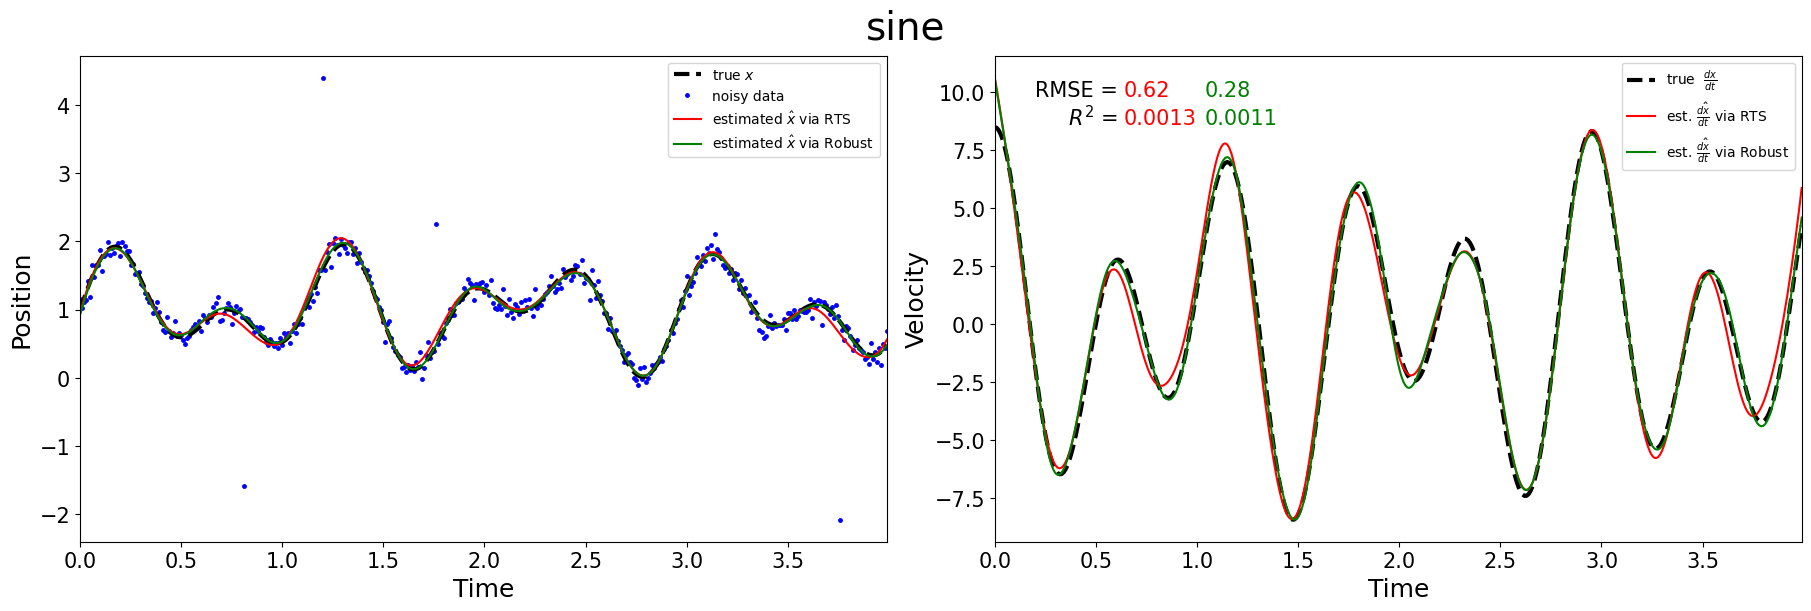

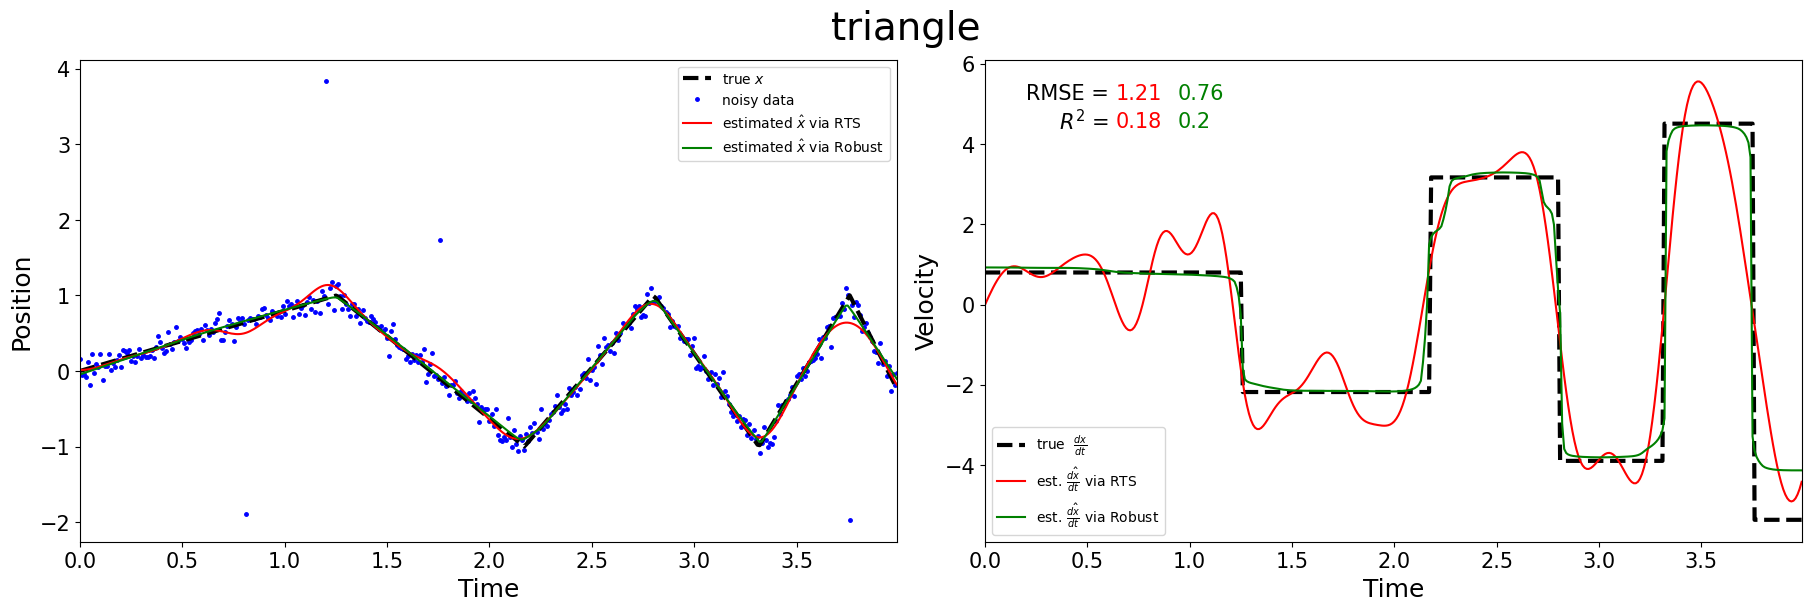

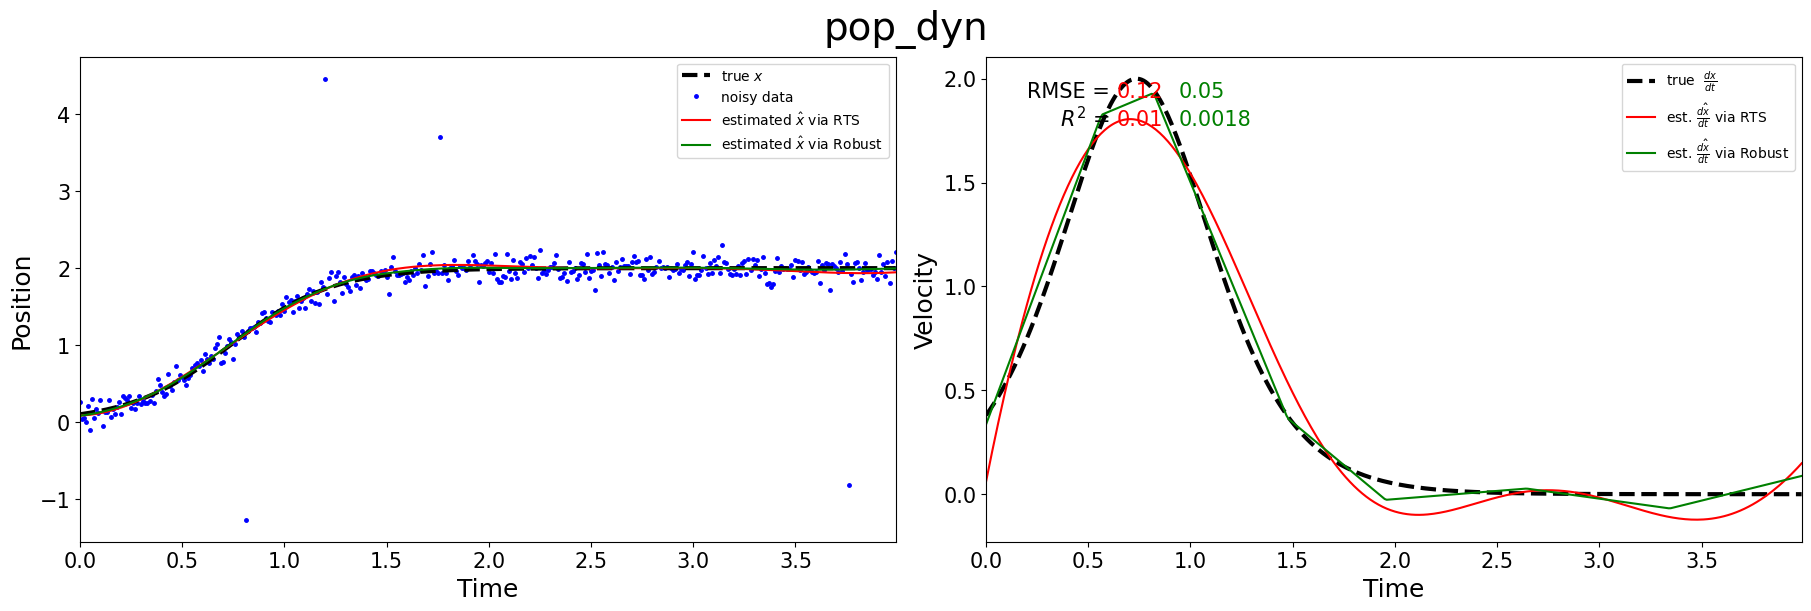

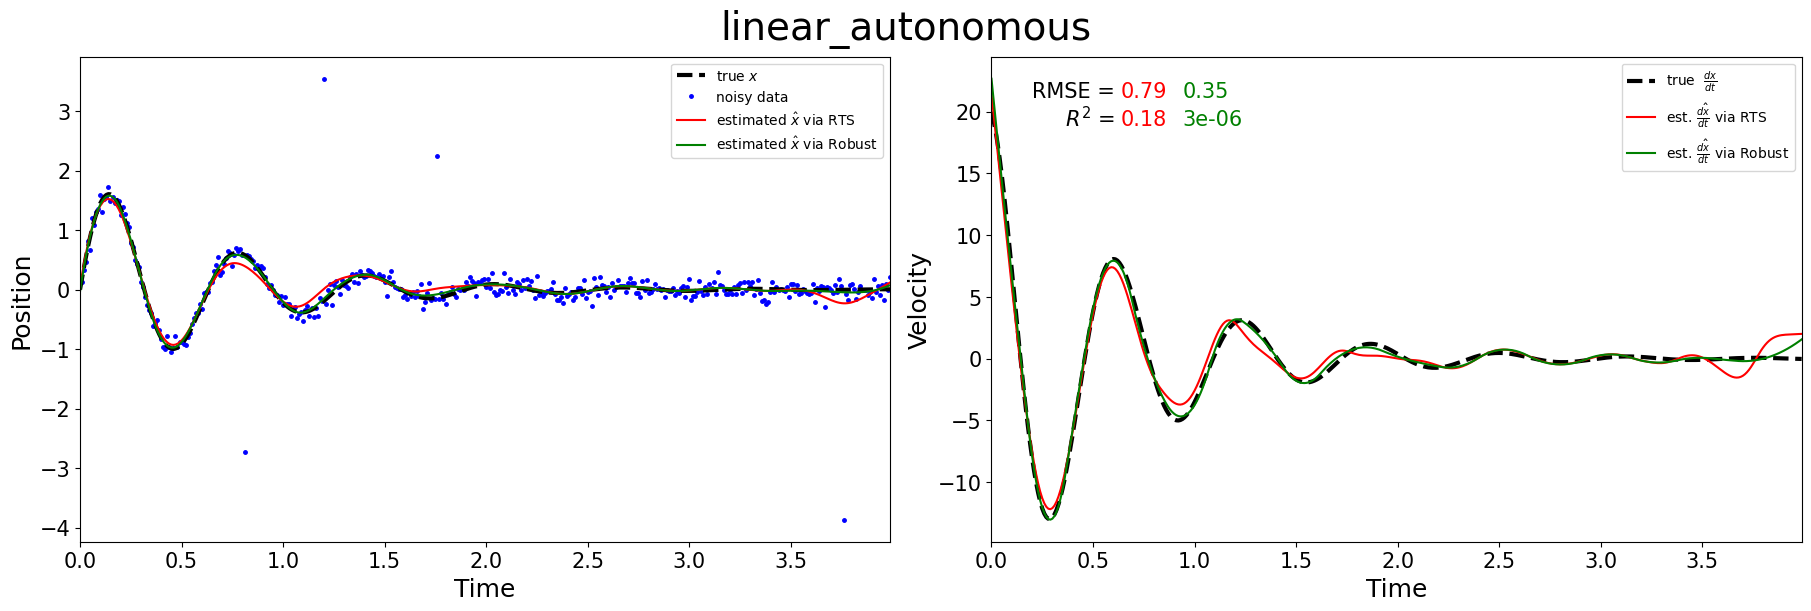

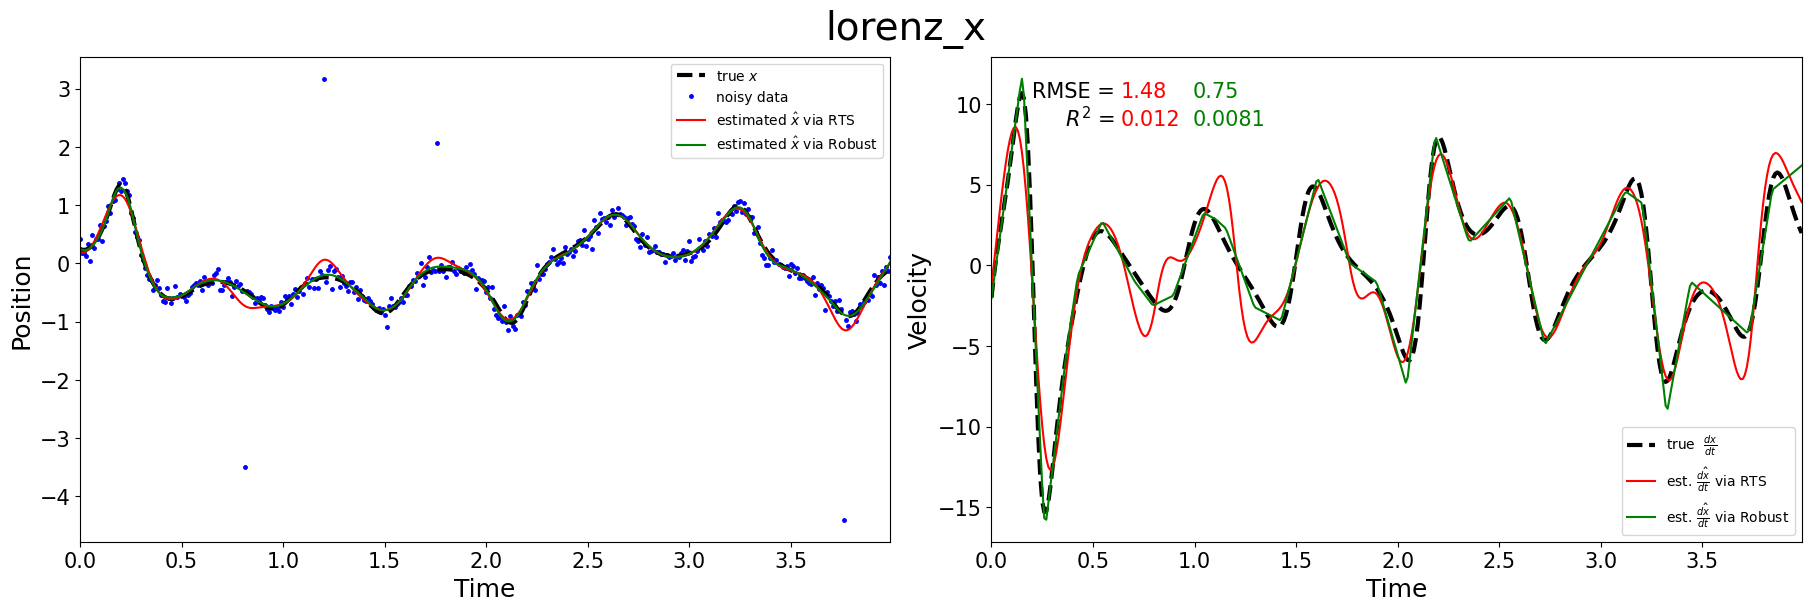

In [3]:
dt = 0.01
for problem in [pi_cruise_control, sine, triangle, pop_dyn, linear_autonomous, lorenz_x]:
	x, x_truth, dxdt_truth = problem(duration=4, noise_type='normal',
	                                noise_parameters=[0, 0.1], dt=dt, outliers=True)
	t = np.arange(0, dt*len(x), dt)

	for method in [rtsdiff, robustdiff]:
		if (method, problem) in cache:
			params = cache[(method, problem)]
		else:
			start = time()
			params, val = optimize(method, x, dt, dxdt_truth=dxdt_truth)
			print(f'Optimal parameters for {method.__name__} on {problem.__name__}: {params}, found in {time() - start:.2f} seconds')
		
		x_hat, dxdt_hat = method(x, dt, **params)
		rmse_dxdt = evaluate.rmse(dxdt_truth, dxdt_hat)
		R_sqr = evaluate.error_correlation(dxdt_truth, dxdt_hat)
		
		if method == rtsdiff:
			fig, axes = evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth, show_error=False)
			axes[1].text(0.05, 0.95, f"RMSE =\n     $R^2$ =", # Show performance metrics for both methods manually
				transform=axes[1].transAxes, fontsize=15, color='black', verticalalignment='top')
			axes[1].text(0.16, 0.95, f"{rmse_dxdt:.2f}\n{R_sqr:.2g}",
				transform=axes[1].transAxes, fontsize=15, color='red', verticalalignment='top', linespacing=1.5)
			w = len(f"{R_sqr:.2g}")
		else:
			axes[0].plot(t, x_hat, color='green', label=".") # need dummy labels here to generate more handles
			axes[1].plot(t, dxdt_hat, color='green', label=".")
			handles, labels = axes[0].get_legend_handles_labels() # need more specific labels, because adding more than usual
			axes[0].legend(handles, labels[:2] + [r"estimated $\hat{x}$ via RTS", r"estimated $\hat{x}$ via Robust"])
			handles, labels = axes[1].get_legend_handles_labels()
			axes[1].legend(handles, [labels[0], r"est. $\hat{\frac{dx}{dt}}$ via RTS", r"est. $\hat{\frac{dx}{dt}}$ via Robust"])
			axes[1].text(0.26 - 0.012*(6 - w), 0.95, f"{rmse_dxdt:.2f}\n{R_sqr:.2g}",
				transform=axes[1].transAxes, fontsize=15, color='green', verticalalignment='top', linespacing=1.5)

	fig.suptitle(f"{problem.__name__}", fontsize=28)